In [1]:
#NOTE: Only tested on a portion of the samples compared to other baselines, results may be skewed
import copy
import collections
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import py3Dmol
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolAlign
from rdkit.Chem import PeriodicTable
from rdkit.Chem.Lipinski import RotatableBondSmarts
import scipy
from scipy import spatial as sci_spatial
import torch
from tqdm.auto import tqdm
import seaborn as sns

ptable = Chem.GetPeriodicTable()

/home/cpsc483_hcd22/.conda/envs/targetdiff2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')  

In [5]:
import sys, os
sys.path.insert(0, os.path.abspath('../'))

# os.chdir("YOURPATH")
from utils.evaluation import eval_bond_length, scoring_func, similarity

In [6]:
MODEL_NAME = 'LatentTargetDiff'

# Load Data

In [123]:
class Globals:
    reference_path = 'sampling_results/crossdocked_test_vina_docked.pt'
    pocket2mol_path = 'sampling_results/pocket2mol_vina_docked.pt'
    ar_path = 'sampling_results/ar_vina_docked.pt'
    targetdiff_path = 'sampling_results/targetdiff_vina_docked.pt'
    our_path = 'sampling_results/LatentTargetDiff.pt'


In [124]:
Globals.reference_results = torch.load(Globals.reference_path)
Globals.reference_results = [[v] for v in Globals.reference_results]
Globals.ar_results = torch.load(Globals.ar_path)
Globals.targetdiff_results = torch.load(Globals.targetdiff_path)
Globals.pocket2mol_results = torch.load(Globals.pocket2mol_path)
Globals.our_results_2 = torch.load(Globals.our_path)

In [125]:
Globals.our_results = [0]*100
for i in range(0, 100):
    Globals.our_results[i] = Globals.our_results_2['all_results']



In [126]:
# print(len(Globals.our_results[0]))
# print(Globals.pocket2mol_results[0][0].keys())
#NOTE: output results file is not the same format as the given baselines in the targetdiff repo, have to adjust a little bit

# Metrics Summary

In [127]:
def print_results(results, show_vina=True):
    qed = [r['chem_results']['qed'] for r in results]
    sa = [r['chem_results']['sa'] for r in results]
    mol_size = [r['mol'].GetNumAtoms() for r in results]
    print('Num results: %d' % len(results))
    if show_vina:
        vina_score_only = [x['vina']['score_only'][0]['affinity'] for x in results]
        vina_min = [x['vina']['minimize'][0]['affinity'] for x in results]
        vina_dock = [r['vina']['dock'][0]['affinity'] for r in results]
        print('[Vina Score] Avg: %.2f | Std: %.2f' % (np.mean(vina_score_only), np.std(vina_score_only)))
        print('[Vina Min]   Avg: %.2f | Std: %.2f' % (np.mean(vina_min), np.std(vina_min)))
        print('[Vina Dock]  Avg: %.4f | Std: %.4f' % (np.mean(vina_dock), np.std(vina_dock)))
        
    print('[QED]  Avg: %.4f | Std: %.4f' % (np.mean(qed), np.std(qed)))
    print('[SA]   Avg: %.4f | Std: %.4f' % (np.mean(sa), np.std(sa)))
    print('[Size] Avg: %.4f | Std: %.4f' % (np.mean(mol_size), np.std(mol_size)))

def compute_high_affinity(vina_ref, results):
    percentage_good = []
    num_docked = []
    qed_good, sa_good = [], []
    for i in range(100):
        score_ref = vina_ref[i]
        pocket_results = [r for r in results[i] if r['vina'] is not None]
        if len(pocket_results) < 50:
            continue
        num_docked.append(len(pocket_results))

        scores_gen = []
        for docked in pocket_results:
            aff = docked['vina']['dock'][0]['affinity']
            scores_gen.append(aff)
            if aff <= score_ref:
                qed_good.append(docked['chem_results']['qed'])
                sa_good.append(docked['chem_results']['sa'])
        scores_gen = np.array(scores_gen)
        percentage_good.append((scores_gen <= score_ref).mean())

    percentage_good = np.array(percentage_good)
    num_docked = np.array(num_docked)

    print('[HF%%]  Avg: %.2f%% | Std: %.2f%% ' % (np.mean(percentage_good)*100, np.std(percentage_good)*100))
    print('[HF-QED]  Avg: %.4f | Std: %.4f ' % (np.mean(qed_good)*100, np.std(qed_good)*100))
    print('[HF-SA]   Avg: %.4f | Std: %.4f ' % (np.mean(sa_good)*100, np.std(sa_good)*100))
    print('[Success%%] %.2f%% ' % (np.mean(percentage_good > 0)*100, ))

## Reference

In [128]:
flat_ref_docked = [r for pr in Globals.reference_results for r in pr]
print_results(flat_ref_docked)

Num results: 100
[Vina Score] Avg: -6.36 | Std: 3.14
[Vina Min]   Avg: -6.71 | Std: 2.50
[Vina Dock]  Avg: -7.4501 | Std: 2.3261
[QED]  Avg: 0.4760 | Std: 0.2050
[SA]   Avg: 0.7277 | Std: 0.1386
[Size] Avg: 22.7500 | Std: 9.9080


In [129]:
vina_ref = [r['vina']['dock'][0]['affinity'] for r in flat_ref_docked]

## AR

In [130]:
flat_ar_docked = [r for pr in Globals.ar_results for r in pr]
print_results(flat_ar_docked)
compute_high_affinity(vina_ref, Globals.ar_results)

Num results: 9295
[Vina Score] Avg: -5.75 | Std: 3.25
[Vina Min]   Avg: -6.18 | Std: 2.42
[Vina Dock]  Avg: -6.7459 | Std: 4.0165
[QED]  Avg: 0.5089 | Std: 0.1767
[SA]   Avg: 0.6366 | Std: 0.1479
[Size] Avg: 17.6815 | Std: 7.8762
[HF%]  Avg: 37.94% | Std: 31.72% 
[HF-QED]  Avg: 52.1360 | Std: 18.5504 
[HF-SA]   Avg: 59.7250 | Std: 14.9267 
[Success%] 91.58% 


## Pocket2Mol

In [132]:
flat_pocket2mol_docked = [r for pr in Globals.pocket2mol_results for r in pr]
print_results(flat_pocket2mol_docked)
compute_high_affinity(vina_ref, Globals.pocket2mol_results)

Num results: 9831
[Vina Score] Avg: -5.14 | Std: 3.17
[Vina Min]   Avg: -6.42 | Std: 2.93
[Vina Dock]  Avg: -7.1515 | Std: 4.8975
[QED]  Avg: 0.5729 | Std: 0.1540
[SA]   Avg: 0.7558 | Std: 0.1240
[Size] Avg: 17.7363 | Std: 9.0242
[HF%]  Avg: 48.36% | Std: 32.17% 
[HF-QED]  Avg: 56.5935 | Std: 16.8338 
[HF-SA]   Avg: 72.3812 | Std: 12.5769 
[Success%] 88.78% 


## TargetDiff

In [133]:
flat_p2m_docked = [r for pr in Globals.targetdiff_results for r in pr]
print_results(flat_p2m_docked)
compute_high_affinity(vina_ref, Globals.targetdiff_results)

Num results: 9036
[Vina Score] Avg: -5.47 | Std: 8.32
[Vina Min]   Avg: -6.64 | Std: 4.94
[Vina Dock]  Avg: -7.8018 | Std: 3.6194
[QED]  Avg: 0.4798 | Std: 0.1990
[SA]   Avg: 0.5846 | Std: 0.1285
[Size] Avg: 24.2371 | Std: 9.0606
[HF%]  Avg: 58.11% | Std: 30.33% 
[HF-QED]  Avg: 49.8408 | Std: 19.5664 
[HF-SA]   Avg: 56.3709 | Std: 12.5134 
[Success%] 98.99% 


## LatentTargetDiff (ours)

In [134]:
flat_ours_docked = [r for pr in Globals.our_results for r in pr] #NOTE: 289, not 28900 due to manual format fix
print_results(flat_ours_docked)
compute_high_affinity(vina_ref, Globals.our_results)

Num results: 28900
[Vina Score] Avg: -5.59 | Std: 1.94
[Vina Min]   Avg: -6.11 | Std: 1.61
[Vina Dock]  Avg: -6.8736 | Std: 1.9979
[QED]  Avg: 0.5386 | Std: 0.1724
[SA]   Avg: 0.6339 | Std: 0.1316
[Size] Avg: 21.8201 | Std: 7.4422
[HF%]  Avg: 43.60% | Std: 34.42% 
[HF-QED]  Avg: 54.0804 | Std: 17.6129 
[HF-SA]   Avg: 59.2851 | Std: 12.4930 
[Success%] 95.00% 


# Atom Distance

In [135]:
def get_all_atom_distance(results):
    atom_distance_list = []
    for pocket in results:
        for ligand in pocket:
            mol = ligand['mol']
            mol = Chem.RemoveAllHs(mol)
            pos = mol.GetConformers()[0].GetPositions()
            dist = sci_spatial.distance.pdist(pos, metric='euclidean')
            atom_distance_list += dist.tolist()
    return np.array(atom_distance_list)
        
Globals.reference_atom_dist = get_all_atom_distance(Globals.reference_results)
Globals.our_atom_dist = get_all_atom_distance(Globals.our_results)
Globals.ar_atom_dist = get_all_atom_distance(Globals.ar_results)
Globals.targetdiff_atom_dist = get_all_atom_distance(Globals.targetdiff_results)
Globals.pocket2mol_atom_dist = get_all_atom_distance(Globals.pocket2mol_results)

In [136]:
def get_all_c_c_distance(results):
    c_c_distance_list = []
    for pocket in results:
        for ligand in pocket:
            mol = ligand['mol']
            mol = Chem.RemoveAllHs(mol)
            for bond_type, dist in eval_bond_length.bond_distance_from_mol(mol):
                if bond_type[:2] == (6, 6):
                    c_c_distance_list.append(dist)
    return np.array(c_c_distance_list)

Globals.reference_c_c_dist = get_all_c_c_distance(Globals.reference_results)
Globals.our_c_c_dist = get_all_c_c_distance(Globals.our_results)
Globals.ar_c_c_dist = get_all_c_c_distance(Globals.ar_results)
Globals.targetdiff_c_c_dist = get_all_c_c_distance(Globals.targetdiff_results)
Globals.pocket2mol_c_c_dist = get_all_c_c_distance(Globals.pocket2mol_results)

In [ ]:
plt.figure(figsize=(15, 10))

LW = 2
LABEL_FONTSIZE = 18
ALPHA = 0.75

BINS = np.linspace(0, 12, 100)
def _plot_other(plot_ylabel=False):
    if plot_ylabel:
        plt.ylabel('Density', fontsize=LABEL_FONTSIZE)
    plt.xlabel('Distance of all atom pairs ($\AA$)', fontsize=LABEL_FONTSIZE)
    plt.ylim(0, 0.5)
    plt.xlim(0, 12)
    
reference_profile = eval_bond_length.get_distribution(Globals.reference_atom_dist, bins=BINS)
def _compute_jsd(atom_dist_list):
    profile = eval_bond_length.get_distribution(atom_dist_list, bins=BINS)
    return sci_spatial.distance.jensenshannon(reference_profile, profile)

ax = plt.subplot(2,3,1)
plt.hist(Globals.reference_atom_dist, bins=BINS, histtype='step', density=True, lw=LW, color='gray', alpha=ALPHA, label='reference')
plt.hist(Globals.pocket2mol_atom_dist, bins=BINS, histtype='step', density=True, lw=LW, color='blue', alpha=ALPHA, label='Pocket2Mol')
jsd = _compute_jsd(Globals.pocket2mol_atom_dist)
ax.text(5, 0.4, f'Pocket2Mol JSD: {jsd:.3f}', fontsize=15, weight='bold')
# plt.title(f'liGAN (JSD={jsd:.3f})')
_plot_other(plot_ylabel=True)
ax = plt.subplot(2,3,2)
plt.hist(Globals.reference_atom_dist, bins=BINS, histtype='step', density=True, lw=LW, color='gray', alpha=ALPHA, label='reference')
plt.hist(Globals.ar_atom_dist, bins=BINS, histtype='step', density=True, lw=LW, color='red', alpha=ALPHA, label='AR')
# jsd = _compute_jsd(Globals.ar_atom_dist)
plt.hist(Globals.targetdiff_atom_dist, bins=BINS, histtype='step', density=True, lw=LW, color='orange', alpha=ALPHA, label='targetdiff')
ar_jsd = _compute_jsd(Globals.ar_atom_dist)
p2m_jsd = _compute_jsd(Globals.targetdiff_atom_dist)
ax.text(4.5, 0.4, f'AR\ntargetdiff', fontsize=15, weight='bold')
ax.text(8.5, 0.4, f'JSD: {ar_jsd:.3f}\nJSD: {p2m_jsd:.3f}', fontsize=15, weight='bold')
# plt.title(f'AR (JSD={jsd:.3f})')
_plot_other()
ax = plt.subplot(2,3,3)
plt.hist(Globals.reference_atom_dist, bins=BINS, histtype='step', density=True, lw=LW, color='gray', alpha=ALPHA, label='reference')
plt.hist(Globals.our_atom_dist, bins=BINS, histtype='step', density=True, lw=LW, color='green', alpha=ALPHA, label=MODEL_NAME)
jsd = _compute_jsd(Globals.our_atom_dist)
ax.text(5, 0.4, f'{MODEL_NAME} JSD:{jsd:.3f}', fontsize=15, weight='bold')
# plt.title(f'{MODEL_NAME} (JSD={jsd:.3f})')
_plot_other()

BINS = np.linspace(0, 2, 100)

def _select_proximal(arr):
    arr = np.array()

def _plot_other(plot_ylabel=False):
    if plot_ylabel:
        plt.ylabel('Density', fontsize=LABEL_FONTSIZE)
    plt.xlabel('Distance of carbon carbon bond ($\AA$)', fontsize=LABEL_FONTSIZE)
    plt.ylim(0, 12)
    plt.xlim(0, 2)
    
reference_profile = eval_bond_length.get_distribution(Globals.reference_c_c_dist, bins=BINS)
def _compute_jsd(atom_dist_list):
    profile = eval_bond_length.get_distribution(atom_dist_list, bins=BINS)
    return sci_spatial.distance.jensenshannon(reference_profile, profile)

ax = plt.subplot(2,3,4)
plt.hist(Globals.reference_c_c_dist, bins=BINS, histtype='step', density=True, lw=LW, color='gray', alpha=ALPHA, label='reference')
plt.hist(Globals.pocket2mol_c_c_dist, bins=BINS, histtype='step', density=True, lw=LW, color='blue', alpha=ALPHA, label='Pocket2Mol')
jsd = _compute_jsd(Globals.pocket2mol_c_c_dist)
ax.text(0.1, 10, f'Pocket2Mol JSD: {jsd:.3f}', fontsize=15, weight='bold')
# plt.title(f'liGAN (JSD={jsd:.3f})')
_plot_other(plot_ylabel=True)
ax = plt.subplot(2,3,5)
plt.hist(Globals.reference_c_c_dist, bins=BINS, histtype='step', density=True, lw=LW, color='gray', alpha=ALPHA, label='reference')
plt.hist(Globals.ar_c_c_dist, bins=BINS, histtype='step', density=True, lw=LW, color='red', alpha=ALPHA, label='AR')
plt.hist(Globals.targetdiff_c_c_dist, bins=BINS, histtype='step', density=True, lw=LW, color='orange', alpha=ALPHA, label='targetdiff')
ar_jsd = _compute_jsd(Globals.ar_c_c_dist)
p2m_jsd = _compute_jsd(Globals.targetdiff_c_c_dist)
ax.text(0.1, 10, f'AR\ntargetdiff', fontsize=15, weight='bold')
ax.text(0.75, 10, f'JSD: {ar_jsd:.3f}\nJSD: {p2m_jsd:.3f}', fontsize=15, weight='bold')
# plt.title(f'AR (JSD={jsd:.3f})')
_plot_other()
ax = plt.subplot(2,3,6)
plt.hist(Globals.reference_c_c_dist, bins=BINS, histtype='step', density=True, lw=LW, color='gray', alpha=ALPHA, label='reference')
plt.hist(Globals.our_c_c_dist, bins=BINS, histtype='step', density=True, lw=LW, color='green', alpha=ALPHA, label=MODEL_NAME)
jsd = _compute_jsd(Globals.our_c_c_dist)
ax.text(0.1, 10, f'{MODEL_NAME} JSD: {jsd:.3f}', fontsize=15, weight='bold')
# plt.title(f'{MODEL_NAME} (JSD={jsd:.3f})')
_plot_other()

plt.tight_layout()
# plt.savefig('output_figures/distance_distribution.pdf')
plt.show()

# Bond Distance

In [138]:
def get_bond_length_profile(results):
    bond_distances = []
    for pocket in results:
        for ligand in pocket:
            mol = ligand['mol']
            mol = Chem.RemoveAllHs(mol)
            bond_distances += eval_bond_length.bond_distance_from_mol(mol)
    return eval_bond_length.get_bond_length_profile(bond_distances)

Globals.reference_bond_length_profile = get_bond_length_profile(Globals.reference_results)
Globals.our_bond_length_profile = get_bond_length_profile(Globals.our_results)
Globals.ar_bond_length_profile = get_bond_length_profile(Globals.ar_results)
Globals.targetdiff_bond_length_profile = get_bond_length_profile(Globals.targetdiff_results)
Globals.pocket2mol_bond_length_profile = get_bond_length_profile(Globals.pocket2mol_results)

In [139]:
REPORT_TYPE = (
    (6,6,1),
    (6,6,2),
    (6,6,4),
    (6,7,1),
    (6,7,2),
    (6,7,4),
    (6,8,1),
    (6,8,2),
    (6,8,4),
)

def _bond_type_str(bond_type) -> str:
    atom1, atom2, bond_category = bond_type
    return f'{atom1}-{atom2}|{bond_category}'

def eval_bond_length_profile(model_profile):
    metrics = {}

    for bond_type in REPORT_TYPE:
        metrics[f'JSD_{_bond_type_str(bond_type)}'] = sci_spatial.distance.jensenshannon(Globals.reference_bond_length_profile[bond_type],model_profile[bond_type])
    return metrics

eval_bond_length_profile(Globals.our_bond_length_profile)

{'JSD_6-6|1': 0.3920146088040081,
 'JSD_6-6|2': 0.48711226016744724,
 'JSD_6-6|4': 0.27865514224485577,
 'JSD_6-7|1': 0.40375947819254965,
 'JSD_6-7|2': 0.5771002766247572,
 'JSD_6-7|4': 0.29942823374115846,
 'JSD_6-8|1': 0.4427172847311607,
 'JSD_6-8|2': 0.43001493941424307,
 'JSD_6-8|4': 0.8325546111576977}

In [140]:
eval_bond_length_profile(Globals.ar_bond_length_profile)

{'JSD_6-6|1': 0.6090847252592992,
 'JSD_6-6|2': 0.6210207716132661,
 'JSD_6-6|4': 0.4504618126310079,
 'JSD_6-7|1': 0.4730538614136365,
 'JSD_6-7|2': 0.6356224885267152,
 'JSD_6-7|4': 0.5514678253305576,
 'JSD_6-8|1': 0.49176438120726135,
 'JSD_6-8|2': 0.5588741374756954,
 'JSD_6-8|4': 0.810528953192532}

In [141]:
eval_bond_length_profile(Globals.targetdiff_bond_length_profile)

{'JSD_6-6|1': 0.36884373598857034,
 'JSD_6-6|2': 0.5047684134329029,
 'JSD_6-6|4': 0.2633830585480587,
 'JSD_6-7|1': 0.3631443132502597,
 'JSD_6-7|2': 0.5504188286292794,
 'JSD_6-7|4': 0.23528955393614812,
 'JSD_6-8|1': 0.4209079543270927,
 'JSD_6-8|2': 0.46103877946328925,
 'JSD_6-8|4': 0.8044862460712345}

In [142]:
eval_bond_length_profile(Globals.pocket2mol_bond_length_profile)

{'JSD_6-6|1': 0.4959307399546982,
 'JSD_6-6|2': 0.5614630763511905,
 'JSD_6-6|4': 0.4158556788727053,
 'JSD_6-7|1': 0.42529234081136563,
 'JSD_6-7|2': 0.6285164082861112,
 'JSD_6-7|4': 0.4873078388654103,
 'JSD_6-8|1': 0.4540257178262056,
 'JSD_6-8|2': 0.5160702401133311,
 'JSD_6-8|4': 0.7828900804172967}

# Rigid

In [143]:
import networkx as nx
from rdkit.Chem.rdchem import BondType
from copy import deepcopy
from collections import OrderedDict

In [144]:
class RotBondFragmentizer():
    def __init__(self, only_single_bond=True):
        self.type = 'RotBondFragmentizer'
        self.only_single_bond = only_single_bond

    # code adapt from Torsion Diffusion
    def get_bonds(self, mol):
        bonds = []
        G = nx.Graph()
        for i, atom in enumerate(mol.GetAtoms()):
            G.add_node(i)
        # nodes = set(G.nodes())
        for bond in mol.GetBonds():
            start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            G.add_edge(start, end)
        for e in G.edges():
            G2 = copy.deepcopy(G)
            G2.remove_edge(*e)
            if nx.is_connected(G2): continue
            l = list(sorted(nx.connected_components(G2), key=len)[0])
            if len(l) < 2: continue
            # n0 = list(G2.neighbors(e[0]))
            # n1 = list(G2.neighbors(e[1]))
            if self.only_single_bond:
                bond_type = mol.GetBondBetweenAtoms(e[0], e[1]).GetBondType()
                if bond_type != BondType.SINGLE:
                    continue
            bonds.append((e[0], e[1]))
        return bonds

    def fragmentize(self, mol, dummyStart=1, bond_list=None):
        if bond_list is None:
            # get bonds need to be break
            bonds = self.get_bonds(mol)
        else:
            bonds = bond_list
        # whether the molecule can really be break
        if len(bonds) != 0:
            bond_ids = [mol.GetBondBetweenAtoms(x, y).GetIdx() for x, y in bonds]
            bond_ids = list(set(bond_ids))
            # break the bonds & set the dummy labels for the bonds
            dummyLabels = [(i + dummyStart, i + dummyStart) for i in range(len(bond_ids))]
            break_mol = Chem.FragmentOnBonds(mol, bond_ids, dummyLabels=dummyLabels)
            dummyEnd = dummyStart + len(dummyLabels) - 1
        else:
            break_mol = mol
            bond_ids = []
            dummyEnd = dummyStart - 1

        return break_mol, bond_ids, dummyEnd
    

def get_clean_mol(mol):
    rdmol = deepcopy(mol)
    for at in rdmol.GetAtoms():
        at.SetAtomMapNum(0)
        at.SetIsotope(0)
    Chem.RemoveStereochemistry(rdmol)
    return rdmol


def replace_atom_in_mol(ori_mol, src_atom, dst_atom):
    mol = deepcopy(ori_mol)
    m_mol = Chem.RWMol(mol)
    for atom in m_mol.GetAtoms():
        if atom.GetAtomicNum() == src_atom:
            atom_idx = atom.GetIdx()
            m_mol.ReplaceAtom(atom_idx, Chem.Atom(dst_atom))
    return m_mol.GetMol()


def ff_optimize(ori_mol, addHs=False, enable_torsion=False):
    mol = deepcopy(ori_mol)
    Chem.GetSymmSSSR(mol)
    if addHs:
        mol = Chem.AddHs(mol, addCoords=True)
    mp = AllChem.MMFFGetMoleculeProperties(mol, mmffVariant='MMFF94s')
    if mp is None:
        return (None, )

    # turn off angle-related terms
    mp.SetMMFFOopTerm(enable_torsion)
    mp.SetMMFFAngleTerm(True)
    mp.SetMMFFTorsionTerm(enable_torsion)

    # optimize unrelated to angles
    mp.SetMMFFStretchBendTerm(True)
    mp.SetMMFFBondTerm(True)
    mp.SetMMFFVdWTerm(True)
    mp.SetMMFFEleTerm(True)
    
#     try:
    ff = AllChem.MMFFGetMoleculeForceField(mol, mp)
    energy_before_ff = ff.CalcEnergy()
    ff.Minimize()
    energy_after_ff = ff.CalcEnergy()
    # print(f'Energy: {energy_before_ff} --> {energy_after_ff}')
    energy_change = energy_before_ff - energy_after_ff
    Chem.SanitizeMol(ori_mol)
    Chem.SanitizeMol(mol)
    rmsd = rdMolAlign.GetBestRMS(ori_mol, mol)
#     except:
#         return (None, )
    return energy_change, rmsd, mol


def frag_analysis_from_mol_list(input_mol_list):
    all_frags_dict = {}
    sg = RotBondFragmentizer()
    for mol in tqdm(input_mol_list):
        frags, _, _ = sg.fragmentize(mol)
        frags = [get_clean_mol(f) for f in Chem.GetMolFrags(frags, asMols=True)]

        for frag in frags:
            num_atoms = frag.GetNumAtoms() - Chem.MolToSmiles(frag).count('*')
            if 2 < num_atoms < 10:
                if num_atoms not in all_frags_dict:
                    all_frags_dict[num_atoms] = []

                mol = deepcopy(frag)
                mol_hs = replace_atom_in_mol(mol, src_atom=0, dst_atom=1)
                mol_hs = Chem.RemoveAllHs(mol_hs)
                all_frags_dict[num_atoms].append(mol_hs)
    
    all_frags_dict = OrderedDict(sorted(all_frags_dict.items()))
    all_rmsd_by_frag_size = {}
    for k, mol_list in all_frags_dict.items():
        n_fail = 0
        all_energy_diff, all_rmsd = [], []
        for mol in mol_list:
            ff_results = ff_optimize(mol, addHs=True, enable_torsion=False)
            if ff_results[0] is None:
                n_fail += 1
                continue
            energy_diff, rmsd, _, = ff_results
            all_energy_diff.append(energy_diff)
            all_rmsd.append(rmsd)
        print(f'Num of atoms: {k} ({n_fail} of {len(mol_list)} fail):   '
              f'\tEnergy {np.mean(all_energy_diff):.2f} / {np.std(all_energy_diff):.2f}' 
              f'\tRMSD   {np.mean(all_rmsd):.2f} / {np.std(all_rmsd):.2f}'
             )
        all_rmsd_by_frag_size[k] = all_rmsd
    return all_frags_dict, all_rmsd_by_frag_size

In [145]:
ours_mols = [r['mol'] for pr in Globals.our_results for r in pr]
ar_mols = [r['mol'] for pr in Globals.ar_results for r in pr]
targetdiff_mols = [r['mol'] for pr in Globals.targetdiff_results for r in pr]
pocket2mol_mols = [r['mol'] for pr in Globals.pocket2mol_results for r in pr]

In [152]:
_, ours_rigid_rmsd = frag_analysis_from_mol_list(ours_mols)
_, ar_rigid_rmsd = frag_analysis_from_mol_list(ar_mols)
_, targetdiff_rigid_rmsd = frag_analysis_from_mol_list(targetdiff_mols)
_, pocket2mol_rigid_rmsd = frag_analysis_from_mol_list(pocket2mol_mols)

100%|██████████| 28900/28900 [03:48<00:00, 126.60it/s]


Num of atoms: 3 (0 of 22800 fail):   	Energy 3669.86 / 54939.19	RMSD   0.06 / 0.06
Num of atoms: 4 (0 of 5600 fail):   	Energy 28.69 / 16.20	RMSD   0.09 / 0.03
Num of atoms: 5 (0 of 3700 fail):   	Energy 20.58 / 11.93	RMSD   0.12 / 0.04
Num of atoms: 6 (0 of 11200 fail):   	Energy 19.96 / 26.33	RMSD   0.10 / 0.08
Num of atoms: 7 (0 of 6200 fail):   	Energy 26.83 / 21.30	RMSD   0.21 / 0.10
Num of atoms: 8 (0 of 3300 fail):   	Energy 199.22 / 650.21	RMSD   0.31 / 0.12
Num of atoms: 9 (0 of 2600 fail):   	Energy 56.25 / 39.44	RMSD   0.33 / 0.10


100%|██████████| 9295/9295 [00:56<00:00, 163.81it/s]


Num of atoms: 3 (0 of 4874 fail):   	Energy 34.78 / 206.94	RMSD   0.09 / 0.07
Num of atoms: 4 (0 of 1769 fail):   	Energy 128.49 / 1630.47	RMSD   0.18 / 0.09
Num of atoms: 5 (1 of 828 fail):   	Energy 41.54 / 48.83	RMSD   0.15 / 0.08
Num of atoms: 6 (0 of 2421 fail):   	Energy 46.71 / 62.16	RMSD   0.20 / 0.09
Num of atoms: 7 (0 of 2039 fail):   	Energy 79.66 / 81.03	RMSD   0.28 / 0.12
Num of atoms: 8 (0 of 1296 fail):   	Energy 115.36 / 459.94	RMSD   0.35 / 0.14
Num of atoms: 9 (0 of 852 fail):   	Energy 169.01 / 216.14	RMSD   0.39 / 0.17


100%|██████████| 9036/9036 [01:23<00:00, 108.42it/s]


Num of atoms: 3 (0 of 6413 fail):   	Energy 38.45 / 1128.39	RMSD   0.06 / 0.05
Num of atoms: 4 (2 of 1331 fail):   	Energy 77.99 / 1562.83	RMSD   0.10 / 0.07
Num of atoms: 5 (12 of 894 fail):   	Energy 22.38 / 30.03	RMSD   0.12 / 0.06
Num of atoms: 6 (0 of 2871 fail):   	Energy 142.97 / 3915.75	RMSD   0.12 / 0.09
Num of atoms: 7 (0 of 2360 fail):   	Energy 3700.58 / 146116.03	RMSD   0.22 / 0.11
Num of atoms: 8 (1 of 1288 fail):   	Energy 8560.93 / 195787.71	RMSD   0.32 / 0.14
Num of atoms: 9 (0 of 903 fail):   	Energy 4447.17 / 115699.87	RMSD   0.38 / 0.16


100%|██████████| 9831/9831 [00:56<00:00, 173.15it/s]


Num of atoms: 3 (0 of 3626 fail):   	Energy 15.32 / 14.38	RMSD   0.07 / 0.03
Num of atoms: 4 (0 of 328 fail):   	Energy 38.03 / 30.27	RMSD   0.11 / 0.07
Num of atoms: 5 (0 of 762 fail):   	Energy 40.84 / 30.41	RMSD   0.13 / 0.06
Num of atoms: 6 (0 of 2138 fail):   	Energy 37.52 / 37.86	RMSD   0.12 / 0.06
Num of atoms: 7 (0 of 1673 fail):   	Energy 41.21 / 29.14	RMSD   0.20 / 0.07
Num of atoms: 8 (0 of 882 fail):   	Energy 51.09 / 34.64	RMSD   0.26 / 0.10
Num of atoms: 9 (0 of 708 fail):   	Energy 71.18 / 44.82	RMSD   0.31 / 0.12


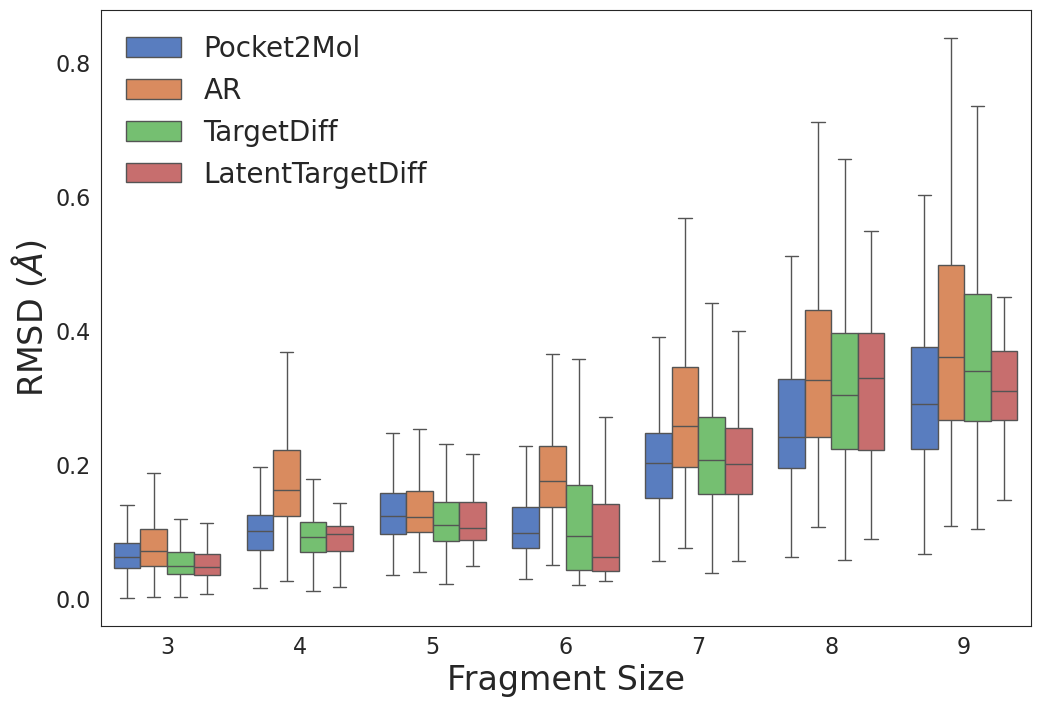

In [154]:
def construct_df(rigid_dict):
    df = []
    for k, all_v in rigid_dict.items():
        for v in all_v:
            df.append({'f_size': k, 'rmsd': v})
    return pd.DataFrame(df)

# sns.set(style="darkgrid")
sns.set_style("white")
sns.set_palette("muted")

tmp_1 = construct_df(ours_rigid_rmsd)
tmp_1['model'] = MODEL_NAME
tmp_2 = construct_df(ar_rigid_rmsd)
tmp_2['model'] = 'AR'
tmp_3 = construct_df(targetdiff_rigid_rmsd)
tmp_3['model'] = 'TargetDiff'
tmp_4 = construct_df(pocket2mol_rigid_rmsd)
tmp_4['model'] = 'Pocket2Mol'
viz_df = pd.concat([tmp_1, tmp_2, tmp_3, tmp_4]).reset_index()
viz_df = viz_df.query('3<=f_size<=9')

LABEL_FONTSIZE = 24
TICK_FONTSIZE = 16
LEGEND_FONTSIZE = 20
plt.figure(figsize=(12, 8))
sns.boxplot(x='f_size', y='rmsd', hue='model', data=viz_df, hue_order=('Pocket2Mol', 'AR', 'TargetDiff', MODEL_NAME), showfliers = False)
plt.xlabel('Fragment Size', fontsize=LABEL_FONTSIZE)
plt.ylabel('RMSD ($\AA{}$)', fontsize=LABEL_FONTSIZE)
plt.xticks(fontsize=TICK_FONTSIZE)
plt.yticks(fontsize=TICK_FONTSIZE)
plt.legend(frameon=False, fontsize=LEGEND_FONTSIZE)
# plt.savefig('output_figures/rigid_rmsd.pdf')
plt.show()

# Vina Score

In [ ]:
our_vina = np.array([np.std([v['vina']['dock'][0]['affinity'] for v in pocket]) for pocket in Globals.our_results])
ar_vina = np.array([np.std([v['vina']['dock'][0]['affinity'] for v in pocket]) if len(pocket) > 0 else 0. for pocket in Globals.ar_results])
targetdiff_vina = np.array([np.std([v['vina']['dock'][0]['affinity'] for v in pocket]) for pocket in Globals.targetdiff_results])

In [ ]:
all_vina = np.stack([our_vina, ar_vina, targetdiff_vina], axis=0)
best_vina_idx = np.argmin(all_vina, axis=0)

In [ ]:
plt.figure(figsize=(25, 6), dpi=100)

ax = plt.subplot(1, 1, 1)
ax.set_prop_cycle('color', plt.cm.Set1.colors)
n_data = len(our_vina)
fig1_idx = np.argsort(our_vina)
ALPHA = 0.75
POINT_SIZE = 128
plt.scatter(np.arange(n_data), ar_vina[fig1_idx], label=f'AR (lowest in {np.mean(best_vina_idx==1)*100:.0f}%)', alpha=ALPHA, s=POINT_SIZE * 0.75)
plt.scatter(np.arange(n_data), targetdiff_vina[fig1_idx], label=f'targetdiff (lowest in {np.mean(best_vina_idx==2)*100:.0f}%)', alpha=ALPHA, s=POINT_SIZE * 0.75)
plt.scatter(np.arange(n_data), our_vina[fig1_idx], label=f'{MODEL_NAME} (lowest in {np.mean(best_vina_idx==0)*100:.0f}%)', alpha=ALPHA, s=POINT_SIZE)

# plt.xticks([])
plt.yticks(fontsize=16)
for i in range(n_data):
    plt.axvline(i, c='0.1', lw=0.2)
plt.xlim(-1, 100)
plt.ylim(-13, -1.5)
# plt.yticks([-10, -8, -6, -4, -2], [-10, -8, -6, -4, '$\geq$-2'], fontsize=25)
plt.yticks([-12, -10, -8, -6, -4, -2], [-12, -10, -8, -6, -4, -2], fontsize=25)
plt.ylabel('std Vina Energy', fontsize=30)
plt.legend(fontsize=25, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.3), frameon=False)
plt.xticks(np.arange(0, 100, 10), [f'target {v}' for v in np.arange(0, 100, 10)], fontsize=25)

plt.tight_layout()
# plt.savefig('output_figures/binding.png')
plt.show()

#NOTE: this graph is also skewed, as I did not sample on all 100 targets